# Additional Question 1
### How to handle cases where the test food images do not belong to any of the 5 target food categories 

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm

## Method 1 
#### - Evaluate confidence value of predicted class
        - Assume that the model will have lower confidence value when predicting images that do not belong to the 5 target food categories
#### - Evaluate entropy of CNN prediction probabilites
        - Entropy measures the randomness of a data
        - Assume that the model prediction probabilities will have high entropy when predicting images that do not belong to the 5 target food categories

In [2]:
def get_model(model_name, model_path, num_classes):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, num_classes)
    if model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        model.fc = nn.Linear(512, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [3]:
class FoodDataset(Dataset):
    def __init__(self, file, transform=None, mode="train"):
        self.transforms = transform
        self.mode = mode
        with open(file, "r") as f:
            self.image_list = f.readlines()

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        label = None
        img_path = self.image_list[index].split("\n")[0].split("\t")[0]
        if self.mode == "train":
            image, label = self.image_list[index].split("\n")[0].split("\t")
            label = int(label)
        else:
            image = self.image_list[index].split("\n")[0]
        image = Image.open(image).convert("RGB")
        image = self.transforms(image)
        if self.mode == "train":
            return img_path, image, label
        else:
            return image

In [4]:
transforms_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_ds = FoodDataset("./data/test.txt", transform=transforms_test)
others_ds = FoodDataset("./data/others.txt", transform=transforms_test)

To observe the difference in entropy and confience value between target classes and other classes, I have used the original test images from the 5 target classes ("test_ds"), and randomly selecting images from all other classes as "others_ds".

- test_ds consists of a total of 1000 images from 5 target classes
- others_ds consists of a total of 1001 images from other classes

In [8]:
cuda_num = 1
device = "cuda:{}".format(cuda_num) if torch.cuda.is_available() else "cpu"
num_classes = 5
model = get_model("resnet34", "checkpoint/resnet34/resnet34_final.pth", num_classes)
model.to(device)

results = list()

def calculate_entropy(output):
    x = -output * output.log()
    return x.sum(dim=1)

for dataset in [test_ds, others_ds]:
    is_in = 1 if dataset == test_ds else 0
    for img_path, img, label in tqdm(dataset):
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            lbl = torch.tensor(label).to(device)

            output = model(img)
            output = torch.nn.functional.softmax(output, dim=1)
            entropy = calculate_entropy(output)
            prediction = torch.argmax(output, dim=1)

            res = {
                "image_path": img_path,
                "is_in": is_in,
                "true": label,
                "predicted": prediction.item(),
                "predicted_class_conf": round(torch.max(output).item(), 5),
                "entropy": round(entropy.item(), 5)
            }
            results.append(res)

results = pd.DataFrame(results)
results

100%|██████████| 1001/1001 [00:07<00:00, 133.81it/s]


,image_path,is_in,true,predicted,predicted_class_conf,entropy
0,data/test/Bak Chor Mee/Bak Chor Mee(2052).jpg,1,0,1,0.41805,1.20386
1,data/test/Bak Chor Mee/Bak Chor Mee(483).jpg,1,0,0,0.88421,0.51416
2,data/test/Bak Chor Mee/Bak Chor Mee(893).jpg,1,0,0,0.92911,0.35398
3,data/test/Bak Chor Mee/Bak Chor Mee(2044).jpg,1,0,0,0.93962,0.31020
4,data/test/Bak Chor Mee/Bak Chor Mee(1064).jpg,1,0,0,0.88906,0.49588
...,...,...,...,...,...,...
1996,data/test/Roti Prata/Roti Prata(18).jpg,0,5,2,0.92223,0.37535
1997,data/test/Roti Prata/Roti Prata(52).jpg,0,5,1,0.48220,1.24858
1998,data/test/Roti Prata/Roti Prata(1702).jpg,0,5,0,0.68104,1.02229
1999,data/test/Roti Prata/Roti Prata(1520).jpg,0,5,2,0.50639,1.08740


Text(0.5, 1.0, 'Box plot - Distribution of Entropy of Output')

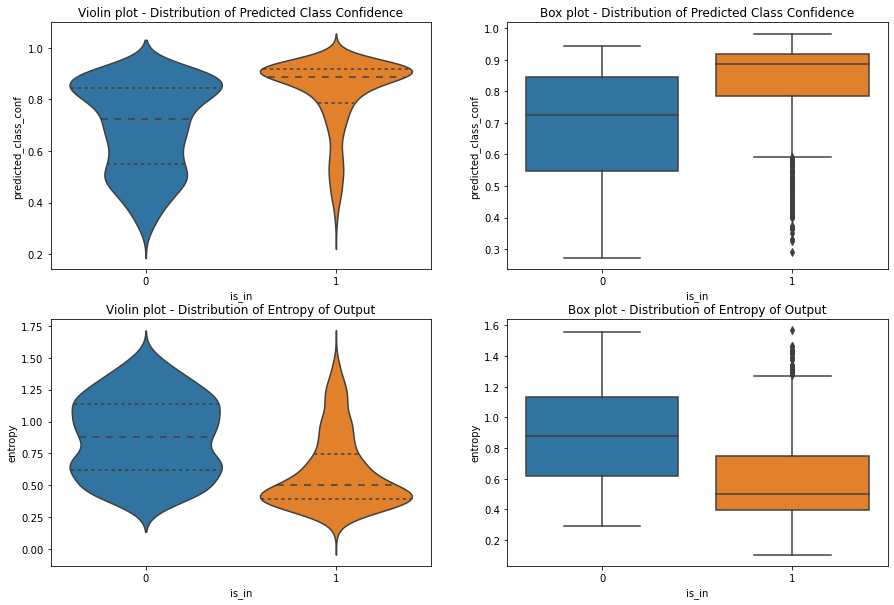

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sb.set_palette("tab10")
sb.violinplot(data=results, x="is_in", y="predicted_class_conf", scale="count", inner="quartile", ax=ax[0][0])
sb.boxplot(data=results, x="is_in", y="predicted_class_conf", ax=ax[0][1])
sb.violinplot(data=results, x="is_in", y="entropy", scale="count", inner="quartile", ax=ax[1][0])
sb.boxplot(data=results, x="is_in", y="entropy", ax=ax[1][1])

ax[0][0].set_title("Violin plot - Distribution of Predicted Class Confidence")
ax[0][1].set_title("Box plot - Distribution of Predicted Class Confidence")
ax[1][0].set_title("Violin plot - Distribution of Entropy of Output")
ax[1][1].set_title("Box plot - Distribution of Entropy of Output")

The graphs above shows the pattern that we expect, i.e. 
* the predicted class probability for the images within the 5 target class is generally higher (model is more confidence to predict images within the target classes)
* the entropy of the images within the target class is generally lower (model output less spread out for images within the target class)

So, in the next step, we try to find a suitable threshold from the distribution of original test images, to find a point where we decide whether the images is out of the 5 classes
* if the predicted class confidence is lower than the confidence threshold, we recognize it as image from other classes 
* if the entropy of model output is higher than the entropy threshol, we recognize it as image from other classes

In [10]:
target_class_predicted_correctly = len(results.loc[(results["is_in"] == 1) & (results["true"] == results["predicted"])])
target_class_total = len(results.loc[results["is_in"] == 1])
print("Target class test accuracy: {} %".format(round(target_class_predicted_correctly / target_class_total * 100, 2)))

Target class test accuracy: 89.0 %


In [11]:
def get_confidence_threshold(percentile):
    return np.percentile(results[results["is_in"] == 1]["predicted_class_conf"], percentile)

conf_res = list()
for percentile in [10, 15, 20, 25, 30, 35, 40, 45, 50]:
    confidence_threshold = get_confidence_threshold(percentile)
    others_detected = len(results.loc[(results["is_in"] == 0) & (results["predicted_class_conf"] < confidence_threshold)])
    others_total = len(results.loc[results["is_in"] == 0])
    conf_res.append({
        "percentile": percentile,
        "% of target class falsely detected as others": percentile,
        "confidence threshold": confidence_threshold,
        "detection rate %": round(others_detected / others_total * 100, 2)
    })

conf_res = pd.DataFrame(conf_res)
conf_res

,percentile,% of target class falsely detected as others,confidence threshold,detection rate %
0,10,10,0.579911,29.37
1,15,15,0.680395,42.66
2,20,20,0.744444,51.85
3,25,25,0.787027,60.14
4,30,30,0.823267,67.63
5,35,35,0.844493,74.73
6,40,40,0.861542,79.62
7,45,45,0.877649,84.12
8,50,50,0.887255,86.81


From the above table, we observe that the higher the confidence threshold, the higher the detection rate, but also result in higher percentage of original target class images being detected as other class

From the table, one of the cases is when we use confidence threshold of 0.680395, we would have detected 42.66% of the images from other classes succesfully, while falsely recognizing 15% of images from the target classes

In [12]:
def get_entropy_threshold(percentile):
    return np.percentile(results[results["is_in"] == 1]["entropy"], percentile)

entropy_res = list()
for percentile in [50, 55, 60, 65, 70, 75, 80, 85, 90]:
    entropy_threshold = get_entropy_threshold(percentile)
    others_detected = len(results.loc[(results["is_in"] == 0) & (results["entropy"] > entropy_threshold)])
    others_total = len(results.loc[results["is_in"] == 0])
    entropy_res.append({
        "percentile": percentile,
        "% of target class falsely detected as others": 100 - percentile,
        "entropy threshold": entropy_threshold,
        "detection rate %": round(others_detected / others_total * 100, 2)
    })

entropy_res = pd.DataFrame(entropy_res)
entropy_res

,percentile,% of target class falsely detected as others,entropy threshold,detection rate %
0,50,50,0.500250,86.51
1,55,45,0.529766,84.42
2,60,40,0.575864,79.72
3,65,35,0.625268,74.23
4,70,30,0.677020,69.23
5,75,25,0.748485,60.84
6,80,20,0.853096,52.75
7,85,15,0.958627,43.66
8,90,10,1.070196,31.47


From the above table, we observe that the lower the entropy threshold, the higher the detection rate, but also result in higher percentage of original target class images being detected as other class

From the table, one of the cases is when we use confidence threshold of 0.958627, we would have detected 43.66% of the images from other classes succesfully, while falsely recognizing 15% of images from the target classes

## Method 2

### Add a new class which include the images from other classes and train a new model

Another method that we tried is by adding a new train class, which consists of images from the other classes.
The model will learn to predict the images of all other classes as the new class

In [13]:
cuda_num = 1
device = "cuda:{}".format(cuda_num) if torch.cuda.is_available() else "cpu"
num_classes = 6
model = get_model("resnet34", "checkpoint/resnet34-6/resnet34_final.pth", num_classes)
model.to(device)

results = list()

for dataset in [test_ds, others_ds]:
    is_in = 1 if dataset == test_ds else 0
    for img_path, img, label in tqdm(dataset):
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            lbl = torch.tensor(label).to(device)

            output = model(img)
            prediction = torch.argmax(output, dim=1)

            res = {
                "image_path": img_path,
                "is_in": is_in,
                "true": label,
                "predicted": prediction.item(),
            }
            results.append(res)

results = pd.DataFrame(results)
results

100%|██████████| 1001/1001 [00:07<00:00, 135.53it/s]


,image_path,is_in,true,predicted
0,data/test/Bak Chor Mee/Bak Chor Mee(2052).jpg,1,0,0
1,data/test/Bak Chor Mee/Bak Chor Mee(483).jpg,1,0,0
2,data/test/Bak Chor Mee/Bak Chor Mee(893).jpg,1,0,0
3,data/test/Bak Chor Mee/Bak Chor Mee(2044).jpg,1,0,0
4,data/test/Bak Chor Mee/Bak Chor Mee(1064).jpg,1,0,0
...,...,...,...,...
1996,data/test/Roti Prata/Roti Prata(18).jpg,0,5,5
1997,data/test/Roti Prata/Roti Prata(52).jpg,0,5,5
1998,data/test/Roti Prata/Roti Prata(1702).jpg,0,5,5
1999,data/test/Roti Prata/Roti Prata(1520).jpg,0,5,5


In [14]:
target_class_predicted_correctly = len(results.loc[(results["is_in"] == 1) & (results["true"] == results["predicted"])])
target_class_total = len(results.loc[results["is_in"] == 1])
print("Target class test accuracy: {} %".format(round(target_class_predicted_correctly / target_class_total * 100, 2)))

Target class test accuracy: 84.6 %


The test accuracy for the test images from target class is lower than before, dropped from 89.0% to 84.6%

This is because the training problrm is now more complex

In [16]:
other_class_predicted_correctly = len(results.loc[(results["is_in"] == 0) & (results["true"] == results["predicted"])])
other_class_total = len(results.loc[results["is_in"] == 0])
print("% others correctly detected as others: {} %".format(round(other_class_predicted_correctly / other_class_total * 100, 2)))

% others correctly detected as others: 72.03 %


The model is able to detect 72.03% of images from other classes successfully.

In [15]:
target_class_predicted_as_others = len(results.loc[(results["is_in"] == 1) & (results["predicted"] == 5)])
target_class_total = len(results.loc[results["is_in"] == 1])
print("% target class falsely detected as others: {} %".format(round(target_class_predicted_as_others / target_class_total * 100, 2)))

% target class falsely detected as others: 6.0 %


However, there is only 6% of target class images being recognized as other class, which is significantly lower than Method 1

For Method 1, if we want 72% of images from other classes to be detected correctly, we would wrongly recognize around 30% of the target class images as others.

# Comparison of Method 1 and 2

- The performance of Method 2 is better than Method 1, for higher detection rate of other class images and lower falsely detection rate for target class images
- However, the limitation of Method 2 is that we still require some images to be "other class". The detection rate highly depends on what kind of images we added into the "other class" to train the model, and what kind of images we want the model to detect as "others".
    - For example, we are using food of other classes to make a new train data class to train the model
    - During testing, we also passed in the food of the other classes, hoping the model the classfied them as other class
    - However, this method does not work when we decide to pass in images of animals to the model, as the "other class" in the train dataset does not contain images of animals
    - Therefore in such cases, Method 1 is more flexible than Method 2